# PROJECT 5 - Vehicle Detection and Tracking

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import cv2
import os

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

import math

%matplotlib inline

## 1. Load Images and making a dataset

Images from all folders were loaded.

### Load

In [2]:
img_names_Vehicles = []

### Vehicles


# GTI_Far
n_images_GTI_Far = 400
count = 0
for i in range(n_images_GTI_Far):
    image_name = 'vehicles/GTI_Far/image' + '{0:04d}'.format(count) + '.png'
    img_names_Vehicles.append(image_name)
    count = count + 1

# GTI_Left
n_images_GTI_Left = 400
count = 0
for i in range(n_images_GTI_Left):
    image_name = 'vehicles/GTI_Right/image' + '{0:04d}'.format(count) + '.png'
    img_names_Vehicles.append(image_name)
    count = count + 1


# GTI_MiddleClose
n_images_GTI_MiddleClose = 400
count = 0
for i in range(n_images_GTI_MiddleClose):
    image_name = 'vehicles/GTI_MiddleClose/image' + '{0:04d}'.format(count) + '.png'
    img_names_Vehicles.append(image_name)
    count = count + 1


# GTI_Right
n_images_GTI_Right = 400
count = 0
for i in range(n_images_GTI_Right):
    image_name = 'vehicles/GTI_Right/image' + '{0:04d}'.format(count) + '.png'
    img_names_Vehicles.append(image_name)
    count = count + 1


# KITTI_extracted
n_images_KITTI_extracted = 5970
count = 0
for i in range(n_images_KITTI_extracted):
    image_name = 'vehicles/KITTI_extracted/' + '{0:04d}'.format(count) + '.png'
    img_names_Vehicles.append(image_name)
    count = count + 1

In [3]:
### Non-Vehicles

img_names_NonVehicles = []

# GTI
n_images_GTI = 3901
count = 1
for i in range(n_images_GTI):
    image_name = 'non-vehicles/GTI/image' + str(count) + '.png'
    img_names_NonVehicles.append(image_name)
    count = count + 1

# Extras
n_images_Extras = 5766
count = 1
for i in range(n_images_Extras):
    image_name = 'non-vehicles/Extras/extra' + str(count) + '.png'
    img_names_NonVehicles.append(image_name)
    count = count + 1

### Dataset

In [4]:
images_Vehicles = []
for fname in img_names_Vehicles:
    try:
        img = mpimg.imread(fname)
        images_Vehicles.append(img)
    except Exception:
        pass

In [5]:
images_NonVehicles = []
for fname in img_names_NonVehicles:
    try:
        img = mpimg.imread(fname)
        images_NonVehicles.append(img)
    except Exception:
        pass

In [6]:
### Shuffle both list of images
from random import shuffle

shuffle(images_Vehicles)
shuffle(images_NonVehicles)

In [7]:
# Shuffle again
shuffle(images_Vehicles)
shuffle(images_NonVehicles)

### Description of the data

In [8]:
print("Total number of images used =", len(images_Vehicles) + len(images_NonVehicles))
print ('Number of Vehicles images: ', len(images_Vehicles))
print ('Number of Non-vehicles images: ', len(images_NonVehicles))

Total number of images used = 15138
Number of Vehicles images:  6170
Number of Non-vehicles images:  8968


## 2. Extract the features used for classification

In [9]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [10]:
### COLOR CLASSIFY

# Function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [11]:
### HOG CLASSIFY
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


In [12]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        #4) Append features to list
        img_features.append(spatial_features)
        
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        
        #6) Append features to list
        img_features.append(hist_features)

        
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        #8) Append features to list ####3
        img_features.append(hog_features)

    #my_array = 
    #9) Return concatenated array of features
    return np.reshape(np.concatenate(img_features), (1,-1))

## 3. Build and train the classifier

In [13]:
# Function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # Read in each one by one
        #image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [14]:
cars = images_Vehicles
notcars = images_NonVehicles

sample_size = 4000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]


### Parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

### Extract Features

In [15]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

C:\Users\rafael\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [16]:
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

C:\Users\rafael\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [17]:
X = np.vstack((car_features, notcar_features)).astype(np.float64) 

In [18]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

In [19]:
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

### Labels

In [20]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

### Train the classifier

In [21]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split( scaled_X, y, test_size=0.15, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
svc_save = svc
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
25.77 Seconds to train SVC...
Test Accuracy of SVC =  0.9908


## 4. Slide the window and identify car on an image

In [22]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [23]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [24]:
# img is 0-255 image
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features)).reshape(1, -1))
            
            # Just HOG
            #test_features = X_scaler.transform(np.hstack(hog_features).reshape(1, -1))
            
            test_prediction = svc.predict(test_features)
            
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
                
    return draw_img, bbox_list

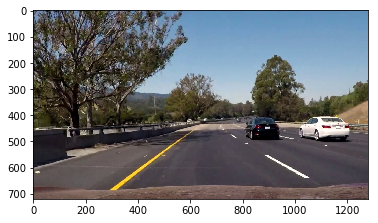

In [25]:
### Problematic frame with commom false positives
img_test = mpimg.imread('image11.jpg')
plt.imshow(img_test)

## 5. Filter out the false positives

In [26]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    bounding_box_list = []
    detected = False
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bounding_box_list.append(bbox)
        
        # Distance between two points
        D = np.sqrt((np.min(nonzerox) - np.max(nonzerox))**2 + (np.min(nonzeroy) - np.max(nonzeroy))**2)
        
        if D > 40.0:        
            detected = True
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
            
        
    # Return the image
    return img , bounding_box_list, detected

C:\Users\rafael\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


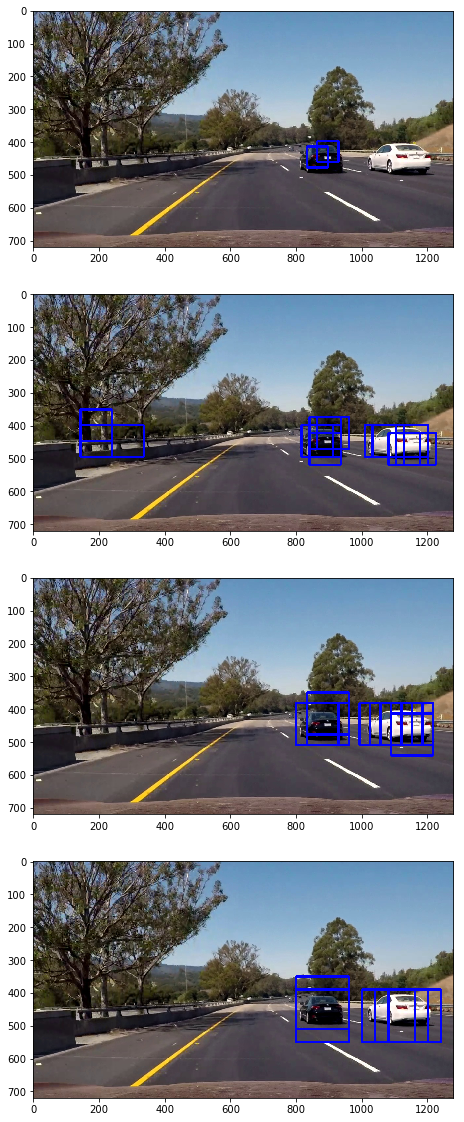

In [27]:
ystart = 350
ystop = 650
scale = 1.0
 
img = img_test  
bboxes = []

f = plt.figure(1)
f.set_figheight(20)
f.set_figwidth(20)


for i in range(4):
    out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.append(bbox_list)
    scale = scale + 0.5
    plt.subplot(4,1,i + 1)
    plt.imshow(out_img)

bboxes = np.concatenate((bboxes[0],bboxes[1],bboxes[2],bboxes[3]), axis=0)

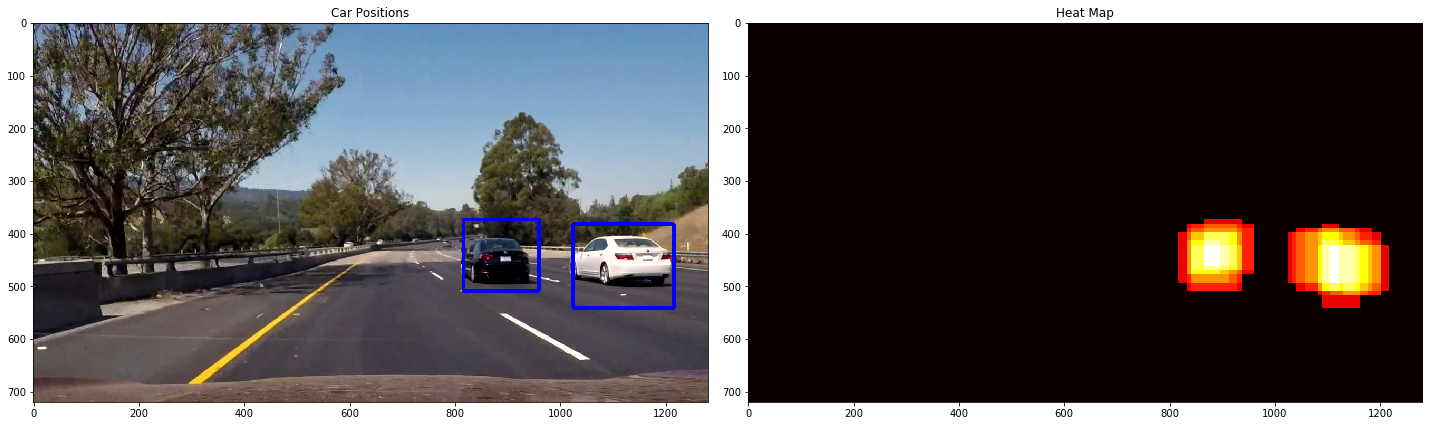

In [29]:
image = img_test
heat = np.zeros_like(image[:,:,0]).astype(np.float)


# Add heat to each box in box list
heat = add_heat(heat, bboxes)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img, bounding_box_list, detected = draw_labeled_bboxes(np.copy(image), labels)

f = plt.figure(1)
f.set_figheight(20)
f.set_figwidth(20)

plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
f.tight_layout()




## 6. Calculate the distance

In [30]:
### CURVATURE MEASURE

# This function receive the centers of the rectangles drawed
def distance_measure(bbox):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #bbox = ((x1, y1), (x2, y2))
    x1 = (bbox[0][0])*1.0
    y1 = (bbox[0][1])*1.0
    x2 = (bbox[1][0])*1.0
    y2 = (bbox[1][1])*1.0
    
    center = (((x1+x2)/2 , (y1+y2)/2))
    center_m = (center[0]*xm_per_pix , center[1]*ym_per_pix)
    
    # (720, 1280, 3) Image shape
    
    car_front = (((1280./2)*xm_per_pix), ((720.)*ym_per_pix))
    
    distance = np.sqrt((car_front[0] - center_m[0])**2 + (car_front[1] - center_m[1])**2)

    return distance, center

## 7. Run the pipeline on the video

In [31]:
### COLLECT AND SAVE FRAMES FROM VIDEO 

def video_to_frames(video, path_output_dir):
    # extract frames from a video and save to directory as 'x.png' where 
    # x is the frame index
    pipeline_images = []
    vidcap = cv2.VideoCapture(video)
    count = 0
    while vidcap.isOpened():
        success, image = vidcap.read()
        if success:
            cv2.imwrite(os.path.join(path_output_dir, 'image%d.jpg') % count, image)
            count += 1
            image_string = 'image%d.jpg' %count
            pipeline_images.append(image_string) #list of images in ascending order
        else:
            break
    cv2.destroyAllWindows()
    vidcap.release()
    return pipeline_images

In [32]:
# pipeline_images = video_to_frames('CarND-Vehicle-Detection-master/test_video.mp4', 'test_input_images/')

In [33]:
### MAKE A VIDEO

from moviepy.editor import VideoFileClip
from IPython.display import HTML
from moviepy.editor import ImageSequenceClip

### Test Video

In [36]:
font_type1 = ImageFont.truetype("Arial.ttf",40)  
font_type2 = ImageFont.truetype("Arial.ttf",25)  

ystart = 350
ystop = 650

input_images = []

count = 0
for i in range(35):
    image_name = 'test_input_images/image' + str(count) + '.jpg'
    input_images.append(image_name)
    count = count + 1


count = 0
list_of_box_list = []
frame_number = 0
for fname in input_images:
    # Read the frame
    frame = mpimg.imread(fname) # array image
    
    frame_number += 1
    
    scale = 1.0
    
    
    

    img = frame      
    box_list = []    
    for i in range(4):
        out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                       orient, pix_per_cell, cell_per_block,
                                       spatial_size, hist_bins)
        
        box_list = box_list + bbox_list
        img = out_img
        scale = scale + 0.5
        
    # Avoiding Error empty tuple when no detection
    if len(box_list) == 0:
        box_list = [((0, 0),(1,1))]    
        
    list_of_box_list.append(box_list)
    
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Average Heatmap
    if frame_number >= 10:
          
        # concatenate the last 10 box_list
        heat_frames = np.concatenate((list_of_box_list[frame_number - 10],
                                     list_of_box_list[frame_number - 9],
                                     list_of_box_list[frame_number - 8],
                                     list_of_box_list[frame_number - 7],
                                     list_of_box_list[frame_number - 6],
                                     list_of_box_list[frame_number - 5],
                                     list_of_box_list[frame_number - 4],
                                     list_of_box_list[frame_number - 3],
                                     list_of_box_list[frame_number - 2],
                                     list_of_box_list[frame_number - 1]), axis = 0)
    

        # Add heat to each box in box list
        heat = add_heat(heat,heat_frames)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,(15*10))
        
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img, bounding_box_list, detected = draw_labeled_bboxes(np.copy(frame), labels)
        
        im = Image.fromarray(draw_img)
        output_image_name = 'test_output_images/' + 'image' + str(count) + '.jpg'
        im.save(output_image_name)
        
        if detected == True:
            drawn = ImageDraw.Draw(im)
            str_warning = 'CARS DETECTED: ' +  str(len(bounding_box_list))
            drawn.text(xy=(530,130),text=str_warning, fill=(200,0,0), font=font_type1)
            for i in range(len(bounding_box_list)):               
                distance, center = distance_measure(bounding_box_list[i])
                
                str_distances = '-> Car ' + str(i+1) + ': ' + '{:.2f}'.format(distance)  + ' m'
                drawn.text(xy=(540,100*i+170),text=str_distances, fill=(255,255,255), font=font_type1)
                
                str_car_number =  str(i+1)
                drawn.text(xy=((center[0] - 10), (center[1] - 10)),text=str_car_number, fill=(200,0,0), font=font_type2)
                
                im.save(output_image_name)
     
    else:   
        
        # Add heat to each box in box list
        heat = add_heat(heat,box_list)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,15)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img, bounding_box_list, detected = draw_labeled_bboxes(np.copy(frame), labels)
        
        im = Image.fromarray(draw_img)
        output_image_name = 'test_output_images/' + 'image' + str(count) + '.jpg'
        im.save(output_image_name)


    
    
    count = count + 1





C:\Users\rafael\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [37]:
### Test Video

test_output_images = []

count = 0
for i in range(35):
    image_name = 'test_output_images/image' + str(count) + '.jpg'
    test_output_images.append(image_name)
    count = count + 1

seq = ImageSequenceClip(test_output_images, fps=25)
    
video_file = 'my_test_video' + '.mp4'
seq.write_videofile(video_file)


MoviePy: building video file my_test_video.mp4
----------------------------------------

Writing video into my_test_video.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.81it/s]


Done writing video in my_test_video.mp4 !
Your video is ready !


### Final Video

In [39]:
ystart = 350
ystop = 650

input_images = []

count = 0
for i in range(1257):
    image_name = 'input_images/image' + str(count) + '.jpg'
    input_images.append(image_name)
    count = count + 1


count = 0
list_of_box_list = []
frame_number = 0
for fname in input_images:
    # Read the frame
    frame = mpimg.imread(fname) # array image
    
    frame_number += 1
    
    scale = 1.0
    
    

    img = frame      
    box_list = []    
    for i in range(4):
        out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                       orient, pix_per_cell, cell_per_block,
                                       spatial_size, hist_bins)
        
        box_list = box_list + bbox_list
        img = out_img
        scale = scale + 0.5
        
    if len(box_list) == 0:
        box_list = [((0, 0),(1,1))]    
    
    list_of_box_list.append(box_list)
    
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    if frame_number >= 10:
          
        # concatenate the last 10 box_list
        heat_frames = np.concatenate((list_of_box_list[frame_number - 10],
                                     list_of_box_list[frame_number - 9],
                                     list_of_box_list[frame_number - 8],
                                     list_of_box_list[frame_number - 7],
                                     list_of_box_list[frame_number - 6],
                                     list_of_box_list[frame_number - 5],
                                     list_of_box_list[frame_number - 4],
                                     list_of_box_list[frame_number - 3],
                                     list_of_box_list[frame_number - 2],
                                     list_of_box_list[frame_number - 1]), axis = 0)
    

        # Add heat to each box in box list
        heat = add_heat(heat,heat_frames)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,(12*10))
        
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img, bounding_box_list, detected = draw_labeled_bboxes(np.copy(frame), labels)
        
        im = Image.fromarray(draw_img)
        output_image_name = 'output_images/' + 'image' + str(count) + '.jpg'
        im.save(output_image_name)
        
        if detected == True:
            drawn = ImageDraw.Draw(im)
            str_warning = 'CARS DETECTED: ' +  str(len(bounding_box_list))
            drawn.text(xy=(530,130),text=str_warning, fill=(200,0,0), font=font_type1)
            for i in range(len(bounding_box_list)):               
                distance, center = distance_measure(bounding_box_list[i])
                
                str_distances = '-> Car ' + str(i+1) + ': ' + '{:.2f}'.format(distance)  + ' m'
                drawn.text(xy=(540,100*i+170),text=str_distances, fill=(255,255,255), font=font_type1)
                
                str_car_number =  str(i+1)
                drawn.text(xy=((center[0] - 10), (center[1] - 10)),text=str_car_number, fill=(200,0,0), font=font_type2)
                
                im.save(output_image_name)
        else:
            drawn = ImageDraw.Draw(im)
            str_warning = 'NO CARS DETECTED'
            drawn.text(xy=(530,130),text=str_warning, fill=(200,0,0), font=font_type1)
            im.save(output_image_name)
            

        
    else:   
        
        # Add heat to each box in box list
        heat = add_heat(heat,box_list)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,15)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img, bounding_box_list, detected = draw_labeled_bboxes(np.copy(frame), labels)
        
        im = Image.fromarray(draw_img)
        output_image_name = 'output_images/' + 'image' + str(count) + '.jpg'
        im.save(output_image_name)
    
    count = count + 1


C:\Users\rafael\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [41]:
output_images = []

count = 0
for i in range(1257):
    image_name = 'output_images/image' + str(count) + '.jpg'
    output_images.append(image_name)
    count = count + 1

seq = ImageSequenceClip(output_images, fps=25)
    
video_file = 'myvideo' + '.mp4'
seq.write_videofile(video_file)


MoviePy: building video file myvideo.mp4
----------------------------------------

Writing video into myvideo.mp4


100%|██████████████████████████████████████████████████████████████████████████████████| 1207/1207 [01:09<00:00, 17.37it/s]


Done writing video in myvideo.mp4 !
Your video is ready !
